<h1 style="text-align: center;">Predicting Emergency Visits using Machine Learning</h1>

<h3 style="text-align: center;">Homework Topic: Self Learning</h3>

<h3 style="text-align: center;">ML Algorithms: Logistic Regression, XGBoost Classifier</h3>

<h4 style="text-align: center;"><b>Prepared By</b>: Suresh Venkatesan | <b>Course</b>: AI in Healthcare(AI 395T) | <b>Prof</b>: Dr. Ying Ding</h4>

### Overview:
This presentation explores the prediction of emergency visits using the MIMIC-III dataset, a rich source of clinical data.

We analyzed patient demographics, diagnoses, and hospital stay (admission and ICU stays) information to build predictive models for emergency visits.

Using both Logistic Regression and XGBoost models, we discovered that factors like age, marital status, length of stay, mortality rates, and the presence of detailed medical records significantly contribute to predicting emergency visits.


### Process Flow Diagram for Predicting Emergency Visits

The process flow diagram below outlines the steps taken to predict emergency visits using machine learning models. The workflow is divided into several key stages, each crucial for building and evaluating the predictive models.

The machine learning process involves preparing data, building a model, evaluating its performance, and gaining insights from the results. The selected model (e.g., Logistic Regression or XGBoost) is used to predict future emergency visits based on patient data.


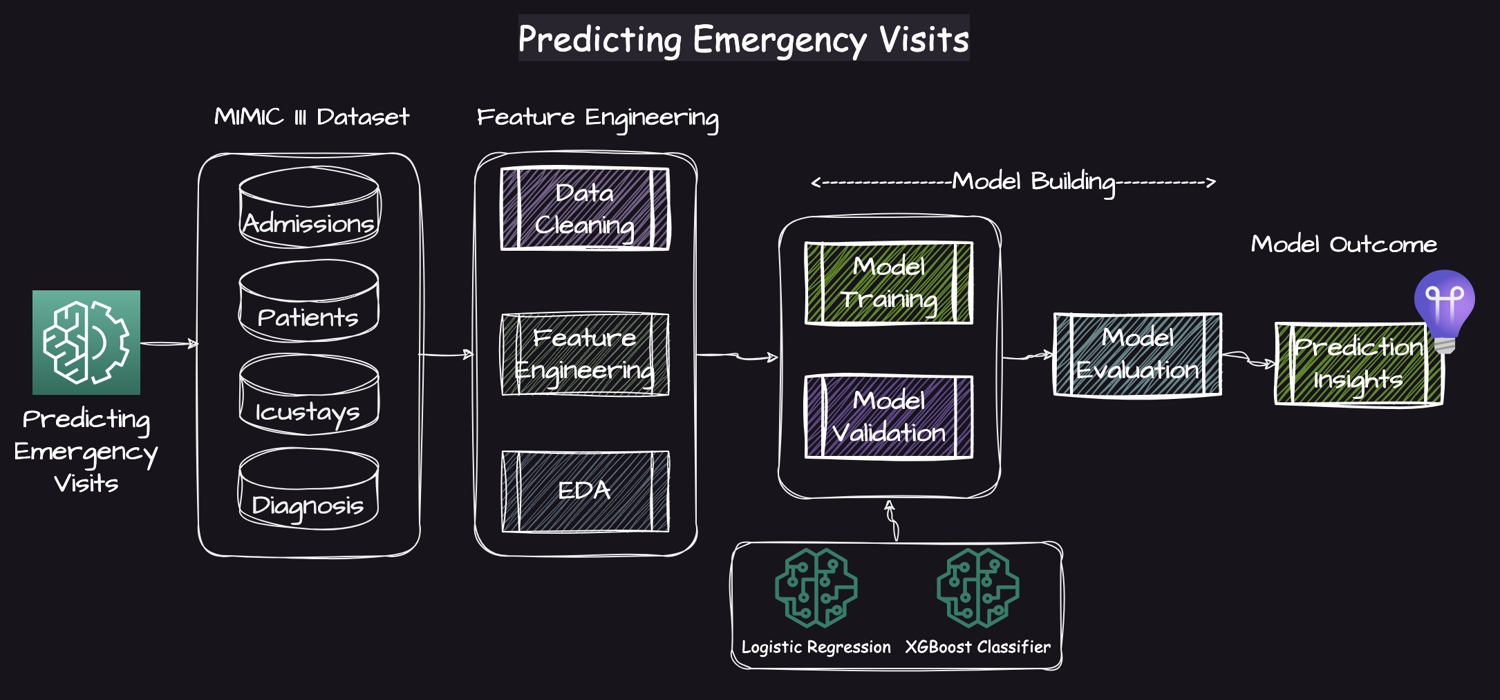

In [1]:
from PIL import Image
# Open the image
image = Image.open("../../doc/Predicting Emergency Visits.png")
# Resize the image to the desired banner size (e.g., width=800, height=200)
banner_image = image.resize((1500, 700))
# Display the resized image
display(banner_image)

### Import Required Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

import warnings
warnings.filterwarnings('ignore')

### Load the MIMIC-III Datasets

In [3]:
# Load necessary datasets (adjust paths as needed)
admissions = pd.read_csv('../data/ADMISSIONS.csv')
patients = pd.read_csv('../data/PATIENTS.csv')
diagnosis = pd.read_csv('../data/DIAGNOSES_ICD.csv')
icustays = pd.read_csv('../data/ICUSTAYS.csv')

# Display initial rows to understand structure
print(admissions.head())
print(patients.head())
print(diagnosis.head())
print(icustays.head())

   ROW_ID  SUBJECT_ID  HADM_ID            ADMITTIME            DISCHTIME  \
0      21          22   165315  2196-04-09 12:26:00  2196-04-10 15:54:00   
1      22          23   152223  2153-09-03 07:15:00  2153-09-08 19:10:00   
2      23          23   124321  2157-10-18 19:34:00  2157-10-25 14:00:00   
3      24          24   161859  2139-06-06 16:14:00  2139-06-09 12:48:00   
4      25          25   129635  2160-11-02 02:06:00  2160-11-05 14:55:00   

  DEATHTIME ADMISSION_TYPE         ADMISSION_LOCATION  \
0       NaN      EMERGENCY       EMERGENCY ROOM ADMIT   
1       NaN       ELECTIVE  PHYS REFERRAL/NORMAL DELI   
2       NaN      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
3       NaN      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
4       NaN      EMERGENCY       EMERGENCY ROOM ADMIT   

          DISCHARGE_LOCATION INSURANCE LANGUAGE           RELIGION  \
0  DISC-TRAN CANCER/CHLDRN H   Private      NaN       UNOBTAINABLE   
1           HOME HEALTH CARE  Medicare      NaN           CA

### Data Cleaning and Feature Engineering

In [4]:
# Encode admission type: Emergency = 1, Others = 0
admissions['EMERGENCY'] = (admissions['ADMISSION_TYPE'] == 'EMERGENCY').astype(int)

In [5]:
# Convert date columns to datetime
admissions['ADMITTIME'] = pd.to_datetime(admissions['ADMITTIME'])
patients['DOB'] = pd.to_datetime(patients['DOB'])

# Calculate age at admission
data = admissions.merge(patients, on='SUBJECT_ID', how='left')

data = data.merge(icustays[['HADM_ID', 'SUBJECT_ID', 'LOS']], on=['SUBJECT_ID', 'HADM_ID'], how='left')

data['ADMITTIME'] = pd.to_numeric(data['ADMITTIME'], errors='coerce')
data['DOB'] = pd.to_numeric(data['DOB'], errors='coerce')
data['AGE'] = ((data['ADMITTIME'] - data['DOB']) // (365 * 24 * 60 * 60 * 1e9)).astype('Int64')
data['DOB'] = pd.to_datetime(data['DOB'])
data['ADMITTIME'] = pd.to_datetime(data['ADMITTIME'])

data = data[(data['AGE'] >= 0) & (data['AGE'] <= 120)]  # Filter invalid ages


In [6]:
# Encode insurance type using Label Encoding
data['INSURANCE'] = LabelEncoder().fit_transform(data['INSURANCE'])

# Encode gender (Female = 0, Male = 1)
data['GENDER'] = LabelEncoder().fit_transform(data['GENDER'])

data['ADMISSION_LOCATION'] = LabelEncoder().fit_transform(data['ADMISSION_LOCATION'])

data['DISCHARGE_LOCATION'] = LabelEncoder().fit_transform(data['DISCHARGE_LOCATION'])

data['DIAGNOSIS'] = LabelEncoder().fit_transform(data['DIAGNOSIS'])

data['HOSPITAL_EXPIRE_FLAG'] = LabelEncoder().fit_transform(data['HOSPITAL_EXPIRE_FLAG'])


In [7]:
# Compress the number of ethnicity categories
data['ETHNICITY'].replace(regex=r'^ASIAN\D*', value='ASIAN', inplace=True)
data['ETHNICITY'].replace(regex=r'^WHITE\D*', value='WHITE', inplace=True)
data['ETHNICITY'].replace(regex=r'^HISPANIC\D*', value='HISPANIC/LATINO', inplace=True)
data['ETHNICITY'].replace(regex=r'^BLACK\D*', value='BLACK/AFRICAN AMERICAN', inplace=True)
data['ETHNICITY'].replace(['UNABLE TO OBTAIN', 'OTHER', 'PATIENT DECLINED TO ANSWER',
                         'UNKNOWN/NOT SPECIFIED'], value='OTHER/UNKNOWN', inplace=True)
data['ETHNICITY'].loc[~data['ETHNICITY'].isin(data['ETHNICITY'].value_counts().nlargest(5).index.tolist())] = 'OTHER/UNKNOWN'
data['ETHNICITY'].value_counts()

WHITE                     41738
OTHER/UNKNOWN              8000
BLACK/AFRICAN AMERICAN     5972
HISPANIC/LATINO            2216
ASIAN                      2040
Name: ETHNICITY, dtype: int64

In [8]:
data['RELIGION'].loc[~data['RELIGION'].isin(['NOT SPECIFIED', 'UNOBTAINABLE'])] = 'RELIGIOUS'

In [9]:
data['RELIGION'].value_counts()

RELIGIOUS        39644
NOT SPECIFIED    12012
UNOBTAINABLE      8310
Name: RELIGION, dtype: int64

In [10]:
data['MARITAL_STATUS'] = data['MARITAL_STATUS'].fillna('UNKNOWN (DEFAULT)')
data['MARITAL_STATUS'].value_counts(dropna=False)

MARRIED              25287
SINGLE               13832
UNKNOWN (DEFAULT)    10579
WIDOWED               6229
DIVORCED              3415
SEPARATED              608
LIFE PARTNER            16
Name: MARITAL_STATUS, dtype: int64

In [11]:
# # Drop unused or no longer needed columns
data.drop(columns=['HADM_ID', 'ADMITTIME', 'ADMISSION_LOCATION','ROW_ID_x', 'ROW_ID_y', 'DISCHARGE_LOCATION', 'DOB',
                  'DISCHTIME', 'DEATHTIME', 'LANGUAGE', 'EDREGTIME', 'EDOUTTIME', 'DOD', 'DOD_HOSP', 'DOD_SSN'], inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59966 entries, 0 to 62721
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   SUBJECT_ID            59966 non-null  int64  
 1   ADMISSION_TYPE        59966 non-null  object 
 2   INSURANCE             59966 non-null  int64  
 3   RELIGION              59966 non-null  object 
 4   MARITAL_STATUS        59966 non-null  object 
 5   ETHNICITY             59966 non-null  object 
 6   DIAGNOSIS             59966 non-null  int64  
 7   HOSPITAL_EXPIRE_FLAG  59966 non-null  int64  
 8   HAS_CHARTEVENTS_DATA  59966 non-null  int64  
 9   EMERGENCY             59966 non-null  int64  
 10  GENDER                59966 non-null  int64  
 11  EXPIRE_FLAG           59966 non-null  int64  
 12  LOS                   58801 non-null  float64
 13  AGE                   59966 non-null  Int64  
dtypes: Int64(1), float64(1), int64(8), object(4)
memory usage: 6.9+ MB


In [12]:
# Create dummy columns for categorical variables
prefix_cols = ['INS', 'ETH', 'MAR', 'REL']
dummy_cols = ['INSURANCE', 'ETHNICITY', 'MARITAL_STATUS', 'RELIGION']
data1 = pd.get_dummies(data, prefix=prefix_cols, columns=dummy_cols)
data1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59966 entries, 0 to 62721
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   SUBJECT_ID                  59966 non-null  int64  
 1   ADMISSION_TYPE              59966 non-null  object 
 2   DIAGNOSIS                   59966 non-null  int64  
 3   HOSPITAL_EXPIRE_FLAG        59966 non-null  int64  
 4   HAS_CHARTEVENTS_DATA        59966 non-null  int64  
 5   EMERGENCY                   59966 non-null  int64  
 6   GENDER                      59966 non-null  int64  
 7   EXPIRE_FLAG                 59966 non-null  int64  
 8   LOS                         58801 non-null  float64
 9   AGE                         59966 non-null  Int64  
 10  INS_0                       59966 non-null  uint8  
 11  INS_1                       59966 non-null  uint8  
 12  INS_2                       59966 non-null  uint8  
 13  INS_3                       599

In [13]:
data1.head()

,SUBJECT_ID,ADMISSION_TYPE,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,EMERGENCY,GENDER,EXPIRE_FLAG,LOS,AGE,...,MAR_DIVORCED,MAR_LIFE PARTNER,MAR_MARRIED,MAR_SEPARATED,MAR_SINGLE,MAR_UNKNOWN (DEFAULT),MAR_WIDOWED,REL_NOT SPECIFIED,REL_RELIGIOUS,REL_UNOBTAINABLE
0,22,EMERGENCY,2206,0,1,1,0,0,1.1438,64,...,0,0,1,0,0,0,0,0,0,1
1,23,ELECTIVE,4608,0,1,0,1,0,1.2641,71,...,0,0,1,0,0,0,0,0,1,0
2,23,EMERGENCY,2470,0,1,1,1,0,1.1862,75,...,0,0,1,0,0,0,0,0,1,0
3,24,EMERGENCY,7528,0,1,1,1,0,0.5124,39,...,0,0,0,0,1,0,0,0,1,0
4,25,EMERGENCY,438,0,1,1,1,0,3.5466,58,...,0,0,1,0,0,0,0,0,0,1


In [14]:
data1 = data1.drop(columns=['ADMISSION_TYPE', 'HOSPITAL_EXPIRE_FLAG'])


In [15]:
data1.shape

(59966, 28)

In [16]:
data['HOSPITAL_EXPIRE_FLAG'].value_counts()

0    53906
1     6060
Name: HOSPITAL_EXPIRE_FLAG, dtype: int64

### Exploratory Data Analysis

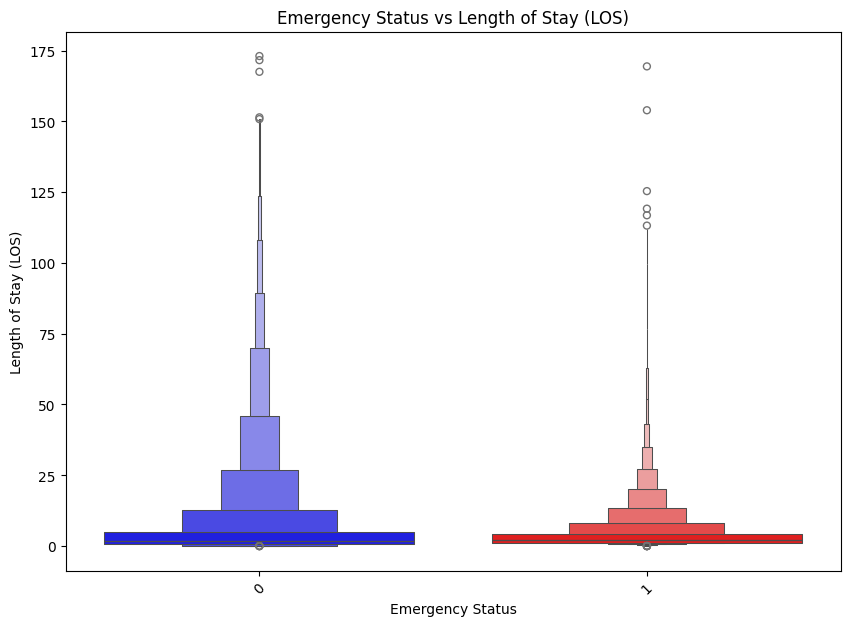

In [17]:
plt.figure(figsize=(10, 7))
sns.boxenplot(x='EMERGENCY', y='LOS', data=data, palette={'0': 'blue', '1': 'red'})
plt.title('Emergency Status vs Length of Stay (LOS)')
plt.xlabel('Emergency Status')
plt.ylabel('Length of Stay (LOS)')
plt.xticks(rotation=45)
plt.show()

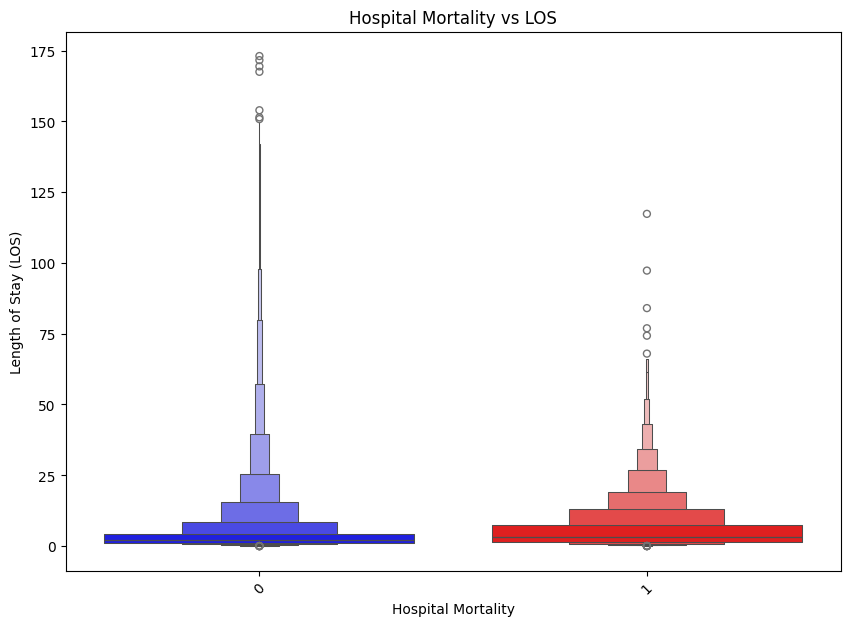

In [18]:
plt.figure(figsize=(10, 7))
sns.boxenplot(x='HOSPITAL_EXPIRE_FLAG', y='LOS', data=data, palette={'0': 'blue', '1': 'red'})
plt.title('Hospital Mortality vs LOS')
plt.xlabel('Hospital Mortality')
plt.ylabel('Length of Stay (LOS)')
plt.xticks(rotation=45)
plt.show()

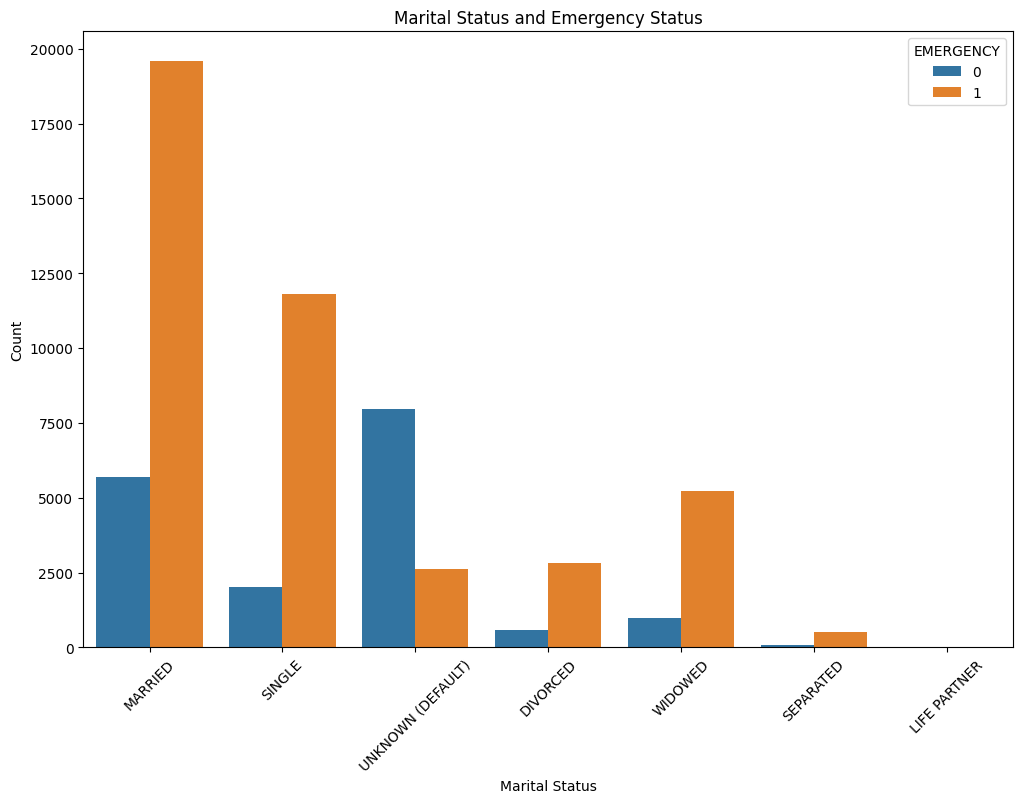

In [19]:
plt.figure(figsize=(12, 8))
sns.countplot(x='MARITAL_STATUS', hue='EMERGENCY', data=data)
plt.title('Marital Status and Emergency Status')
plt.xlabel('Marital Status')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

<Figure size 1200x800 with 0 Axes>

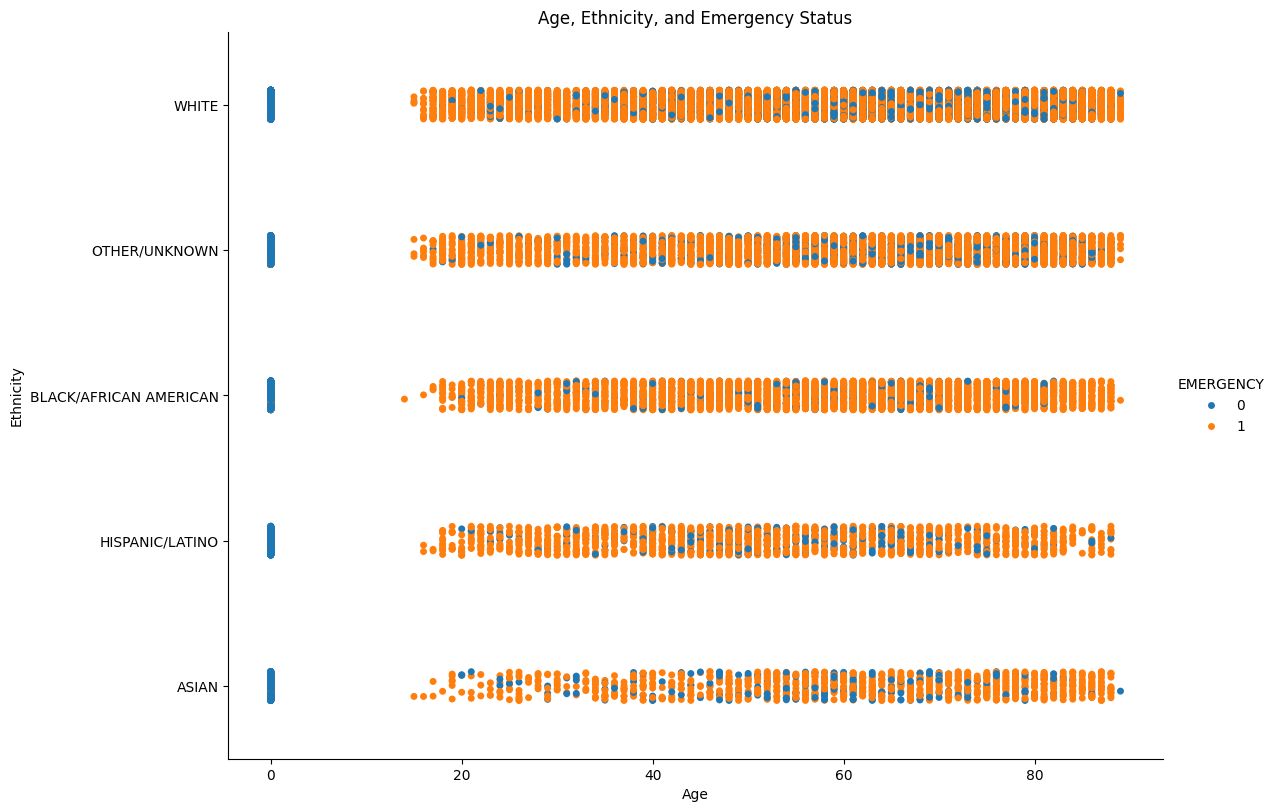

In [20]:
plt.figure(figsize=(12, 8))
sns.catplot(x='AGE', y='ETHNICITY', hue='EMERGENCY', data=data, kind='strip', height=8, aspect=1.5)
plt.title('Age, Ethnicity, and Emergency Status')
plt.xlabel('Age')
plt.ylabel('Ethnicity')
plt.show()

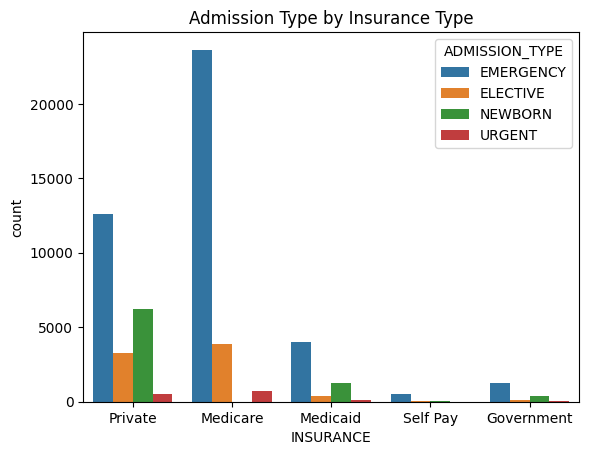

In [21]:
sns.countplot(x='INSURANCE', hue='ADMISSION_TYPE', data=admissions)
plt.title('Admission Type by Insurance Type')
plt.show()


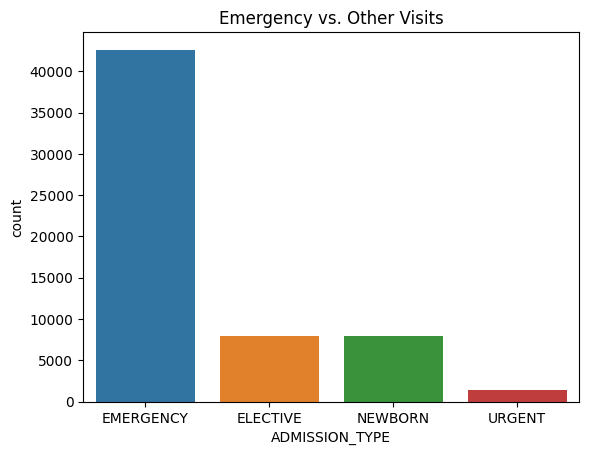

In [22]:
sns.countplot(x='ADMISSION_TYPE', data=data, hue='ADMISSION_TYPE')
plt.title('Emergency vs. Other Visits')
plt.show()


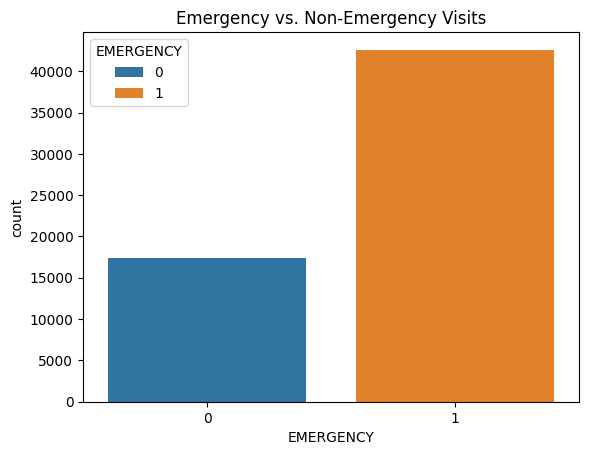

In [23]:
sns.countplot(x='EMERGENCY', data=data, hue='EMERGENCY')
plt.title('Emergency vs. Non-Emergency Visits')
plt.show()


### Age Distribution for Emergency vs. Non-Emergency Visits

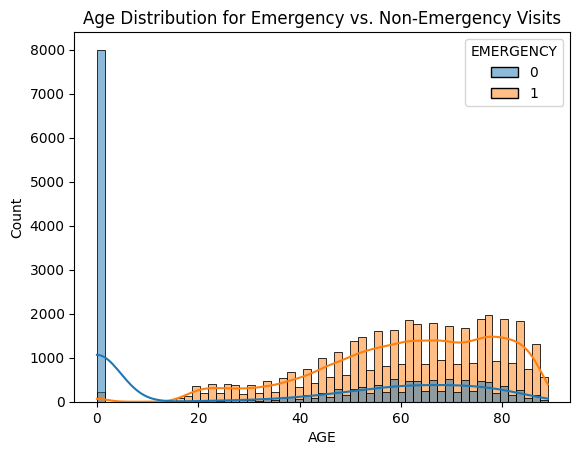

In [24]:
sns.histplot(data=data, x='AGE', hue='EMERGENCY', kde=True)
plt.title('Age Distribution for Emergency vs. Non-Emergency Visits')
plt.show()


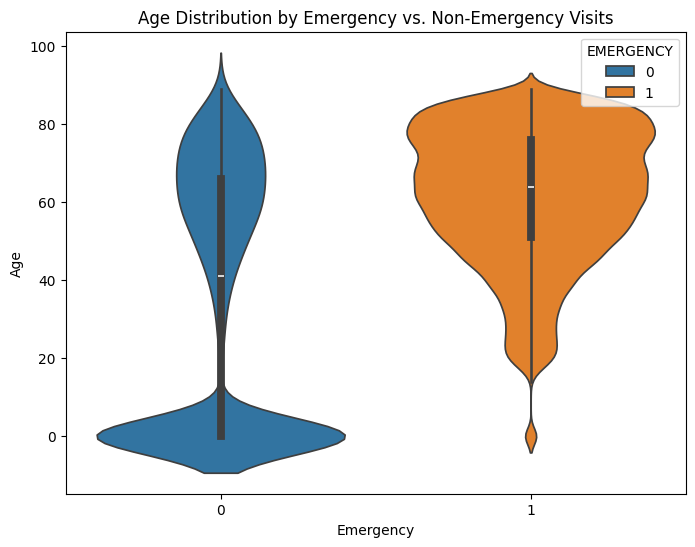

In [25]:
plt.figure(figsize=(8, 6))
sns.violinplot(x='EMERGENCY', y='AGE', data=data, hue='EMERGENCY')
plt.title('Age Distribution by Emergency vs. Non-Emergency Visits')
plt.xlabel('Emergency')
plt.ylabel('Age')
plt.show()

### Age Distribution vs Admission Type

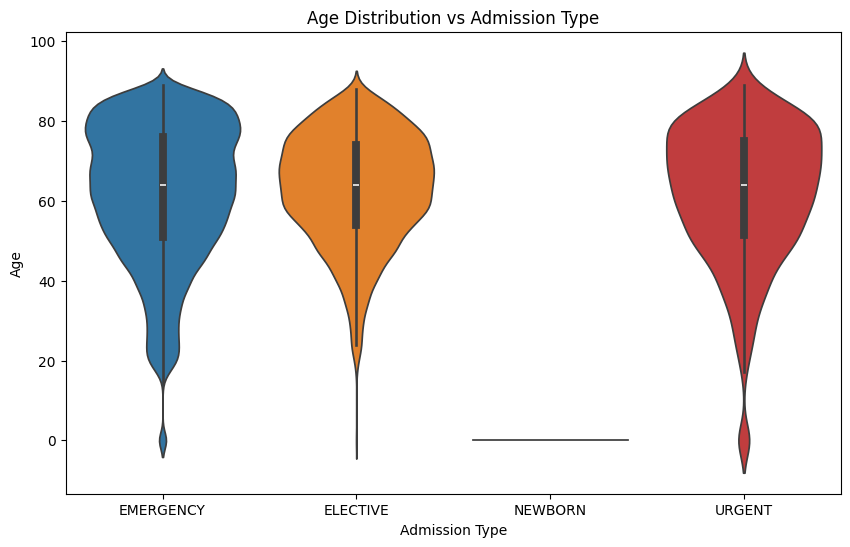

In [26]:
# Box plot: AGE vs ADMISSION_TYPE
plt.figure(figsize=(10, 6))
sns.violinplot(x='ADMISSION_TYPE', y='AGE', data=data, hue='ADMISSION_TYPE')
plt.title('Age Distribution vs Admission Type')
plt.xlabel('Admission Type')
plt.ylabel('Age')
plt.show()

In [27]:
# Target Variable (Length-of-Stay)
emergency_label = data1['EMERGENCY'].values
# Prediction Features
features = data1.drop(columns=['EMERGENCY'])

# Split into train 80% and test 20%
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    emergency_label,
                                                    test_size = .20,
                                                    random_state = 42)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

# Ensure no overlap between training and test sets
X_train_df = pd.DataFrame(X_train, index=features.index[:X_train.shape[0]])
X_test_df = pd.DataFrame(X_test, index=features.index[X_train.shape[0]:])

print("Overlap between training and test sets:")
print(set(X_train_df.index).intersection(set(X_test_df.index)))

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


Training set has 47972 samples.
Testing set has 11994 samples.
Overlap between training and test sets:
set()


### Split Data

In [28]:
data1['SUBJECT_ID'].unique()

array([   22,    23,    24, ..., 98800, 98802, 98805])

In [29]:
# Target Variable (Length-of-Stay)
emergency_label = data1['EMERGENCY'].values
# Prediction Features
features = data1.drop(columns=['EMERGENCY'])

In [30]:
# Split into train 80% and test 20%
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    emergency_label,
                                                    test_size = .20,
                                                    random_state = 42)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 47972 samples.
Testing set has 11994 samples.


In [31]:
# Ensure no overlap between training and test sets
X_train_df = pd.DataFrame(X_train, index=features.index[:X_train.shape[0]])
X_test_df = pd.DataFrame(X_test, index=features.index[X_train.shape[0]:])

print("Overlap between training and test sets:")
print(set(X_train_df.index).intersection(set(X_test_df.index)))


Overlap between training and test sets:
set()


In [32]:
X_train

,SUBJECT_ID,DIAGNOSIS,HAS_CHARTEVENTS_DATA,GENDER,EXPIRE_FLAG,LOS,AGE,INS_0,INS_1,INS_2,...,MAR_DIVORCED,MAR_LIFE PARTNER,MAR_MARRIED,MAR_SEPARATED,MAR_SINGLE,MAR_UNKNOWN (DEFAULT),MAR_WIDOWED,REL_NOT SPECIFIED,REL_RELIGIOUS,REL_UNOBTAINABLE
26851,20854,3924,1,1,1,2.2967,35,0,0,0,...,0,0,0,0,1,0,0,0,1,0
10087,7499,8417,1,1,0,1.9520,48,0,0,0,...,0,0,1,0,0,0,0,0,1,0
35065,29493,269,1,1,0,1.5360,59,0,0,0,...,0,0,1,0,0,0,0,1,0,0
46577,32466,113,1,0,0,1.4099,31,0,0,1,...,0,0,0,0,1,0,0,0,1,0
62605,90707,4529,1,1,0,0.9850,65,0,0,0,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56771,75882,2180,1,0,0,1.4509,47,0,0,0,...,1,0,0,0,0,0,0,1,0,0
39741,32299,12769,1,1,0,0.7018,16,0,1,0,...,0,0,0,0,1,0,0,1,0,0
888,534,13130,1,0,0,0.8354,67,0,0,1,...,0,0,0,0,0,0,1,0,1,0
16411,12234,3391,1,1,0,2.1704,60,0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [33]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


### Build and Train Machine Learning Models

#### Logistic Regression

In [34]:
from sklearn.impute import SimpleImputer

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Fit the logistic regression model
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)


LogisticRegression(random_state=42)

#### XGBoost Classifier

In [35]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

### Model Validation and Evaluation

#### Evaluate Logistic Regression

Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.85      0.49      0.62      3455
           1       0.82      0.96      0.89      8539

    accuracy                           0.83     11994
   macro avg       0.84      0.73      0.76     11994
weighted avg       0.83      0.83      0.81     11994



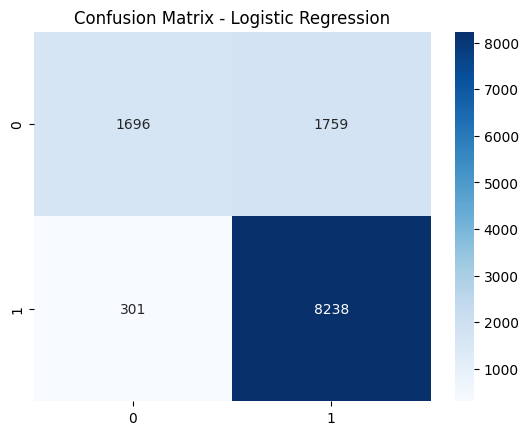

In [36]:
y_pred_logreg = logreg.predict(X_test)
print('Logistic Regression Report:')
print(classification_report(y_test, y_pred_logreg))

conf_matrix = confusion_matrix(y_test, y_pred_logreg)
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()


#### Evaluate XGBoost Classifier

XGBoost Report:
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      3455
           1       0.90      0.97      0.93      8539

    accuracy                           0.90     11994
   macro avg       0.90      0.84      0.87     11994
weighted avg       0.90      0.90      0.89     11994



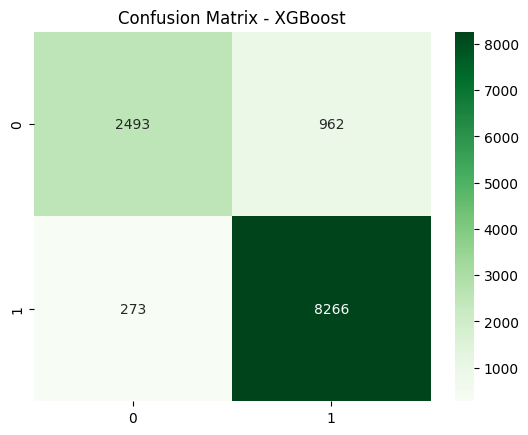

In [37]:
y_pred_xgb = xgb.predict(X_test)
print('XGBoost Report:')
print(classification_report(y_test, y_pred_xgb))

conf_matrix = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(conf_matrix, annot=True, cmap='Greens', fmt='g')
plt.title('Confusion Matrix - XGBoost')
plt.show()


### ROC-AUC Curve Comparison

Logistic Regression ROC-AUC: 0.80
XGBoost ROC-AUC: 0.94


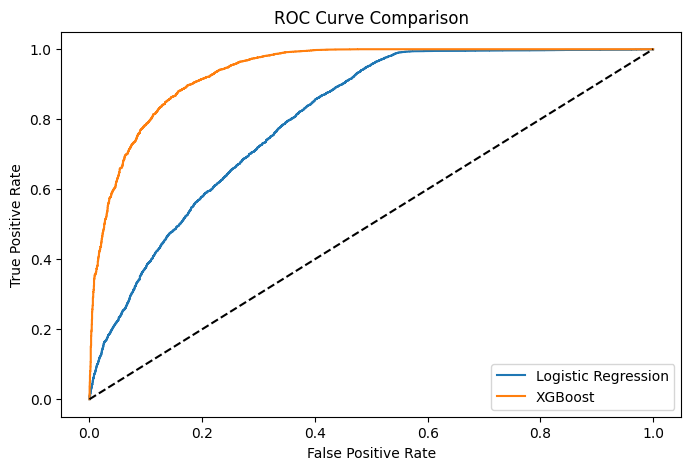

In [38]:
# Calculate ROC-AUC scores
roc_logreg = roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1])
roc_xgb = roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1])

print(f'Logistic Regression ROC-AUC: {roc_logreg:.2f}')
print(f'XGBoost ROC-AUC: {roc_xgb:.2f}')

# Plot ROC curves
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, logreg.predict_proba(X_test)[:, 1])
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb.predict_proba(X_test)[:, 1])

plt.figure(figsize=(8, 5))
plt.plot(fpr_logreg, tpr_logreg, label='Logistic Regression')
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()


### Feature Importance

#### Feature Importance for Logistic Regression

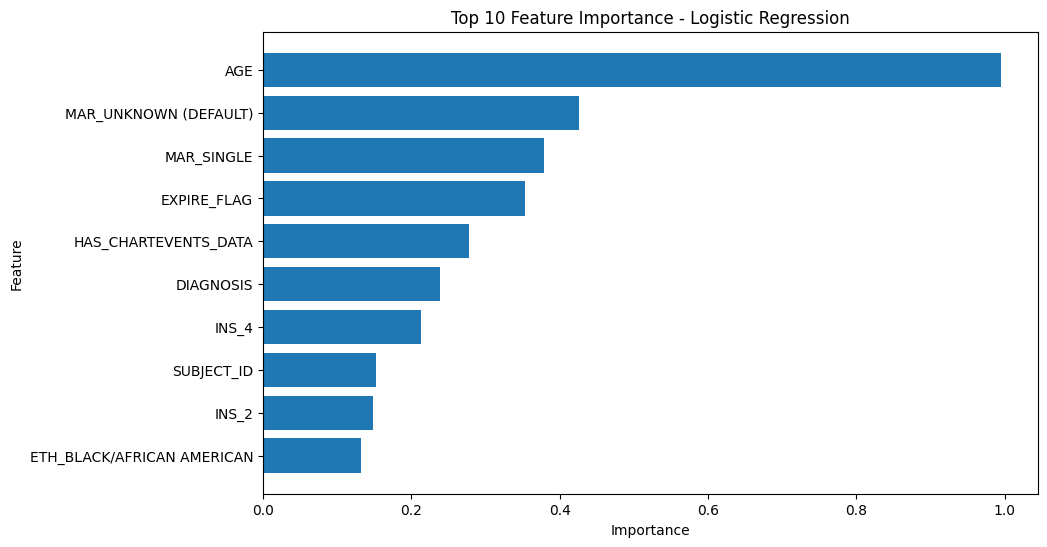

In [39]:
# Get the absolute values of the coefficients
importance = np.abs(logreg.coef_[0])
feature_names = features.columns

# Create a DataFrame for better handling
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Select the top 10 features
top_10_features = feature_importance_df.head(10)

# Plot the top 10 features
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'])
plt.title('Top 10 Feature Importance - Logistic Regression')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.show()

#### Feature Importance for XGBoost

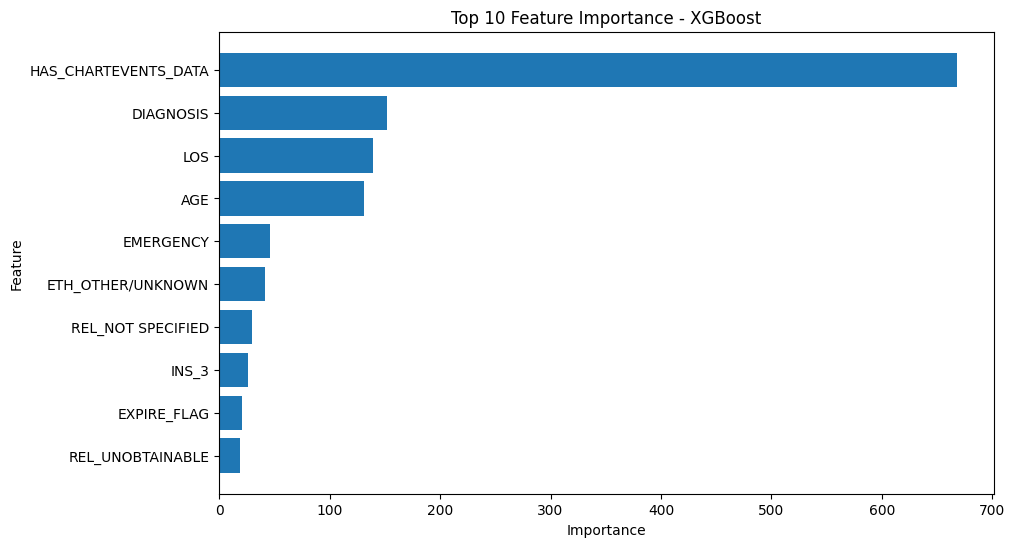

In [40]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Assuming 'model' is your trained XGBoost model
params = {
    'objective': 'binary:logistic',
    'max_depth': 4,
    'eta': 0.1,
    'eval_metric': 'logloss'
}
dtrain = xgb.DMatrix(X_train, label=y_train)
num_boost_round = 100

model = xgb.train(params, dtrain, num_boost_round)

feature_importances = model.get_score(importance_type='weight')
feature_names = data1.columns.drop('SUBJECT_ID')

# Sort the feature importances
sorted_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)

# Select top 10 features
top_n = 10
top_features = sorted_importances[:top_n]
sorted_features = [feature_names[int(k[1:])] for k, v in top_features]
sorted_scores = [v for k, v in top_features]

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_scores)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importance - XGBoost')
plt.gca().invert_yaxis()
plt.show()

### Conclusion and Insights

- **Age and Emergency Visits**: Age is a significant predictor of emergency visits, with older patients more likely to have emergency admissions.
- **Length of Stay (LOS)**: Emergency visits are associated with longer hospital stays, indicating the severity and complexity of cases.
- **Insurance and Marital Status**: Certain insurance types and marital statuses are more prevalent among emergency visits, suggesting socio-economic factors play a role.
- **Model Selection**: The XGBoost model is more effective for predicting emergency visits, highlighting the importance of using advanced machine learning techniques for complex classification tasks.
- **Additional Features**: Exploring additional features and external data sources could enhance the model's accuracy.
- **Real-time Prediction**: Implementing the model in a real-time clinical setting could provide timely insights and improve patient care.

The analysis successfully identified key features and built predictive models for emergency visits, with the XGBoost model showing superior performance. These insights can help healthcare providers better understand and manage emergency admissions.